# Predicting Mathematical Grades

The purpose of this notebook is to use a dataset from the University California Urvine to make predictions on students' math grades based on different independent variables.
This module will utilize python, seaborn, plotly, and sci-kit learn to develop the predictions.

In [26]:
#import libraries 
import pandas  as pd 
import numpy as np #
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import tree
from six import StringIO
from IPython.display import Image  
import pydotplus
import os
plt.rcParams['figure.figsize'] = [18,10]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')
os.environ["PATH"] += os.pathsep + "~/anaconda/bin/graphviz"

In [2]:
df = pd.read_csv("student-mat.csv")

In [3]:
df.shape

(395, 33)

We can see that there are 32 independent variables and 1 dependent variable (G3 = Final Grade)

In [4]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


Lets explore our independent variables with a heatmap to see if there is a correlation among any variables.

## Exploratory data analysis

<AxesSubplot:>

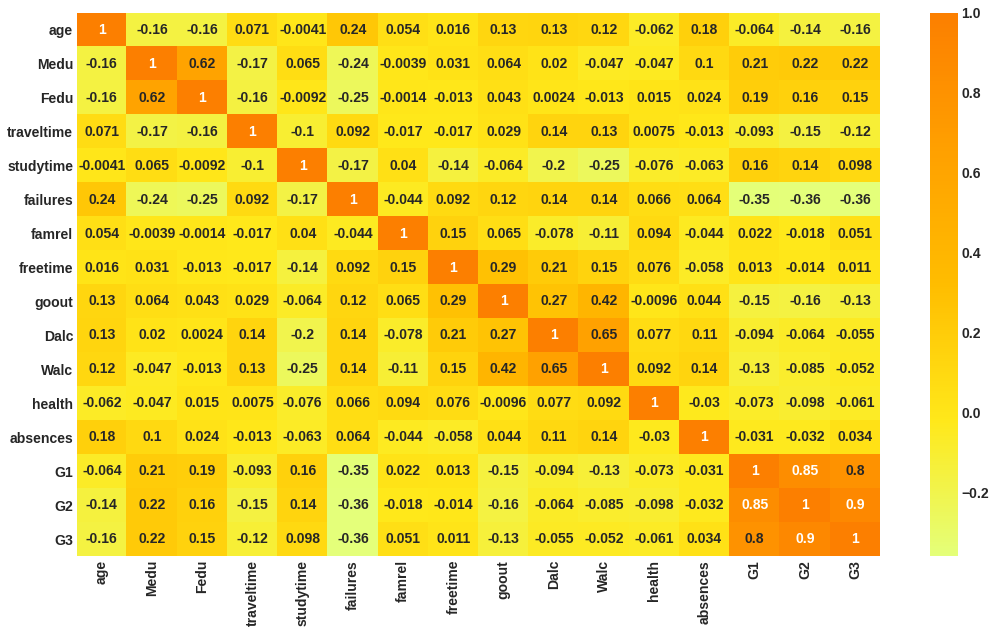

In [5]:
corr = df.corr()
sns.heatmap(corr, cmap='Wistia', annot= True)

We don't see a correlation among variables, except for G1 and G2 (which were grades prior in the semester)

<AxesSubplot:xlabel='G3', ylabel='Count'>

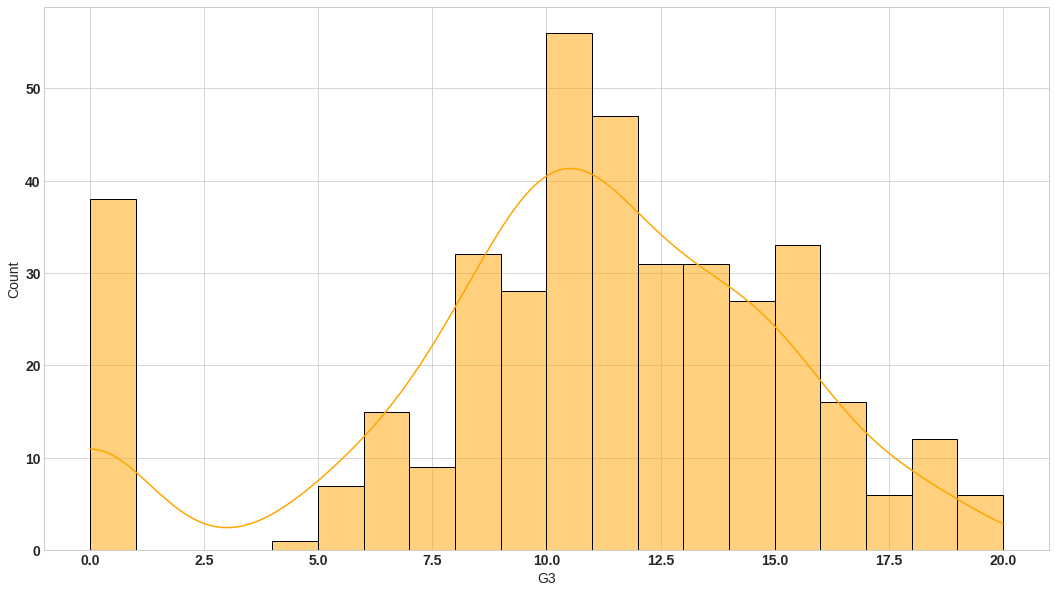

In [6]:
sns.histplot(data=df, x="G3", bins = 20, color="orange", kde=True)

We can see that there is a somewhat normal distribution for the grades except for the people that scored 0. Lets explore some comparions of binary data to see if any discrepencies stand out.

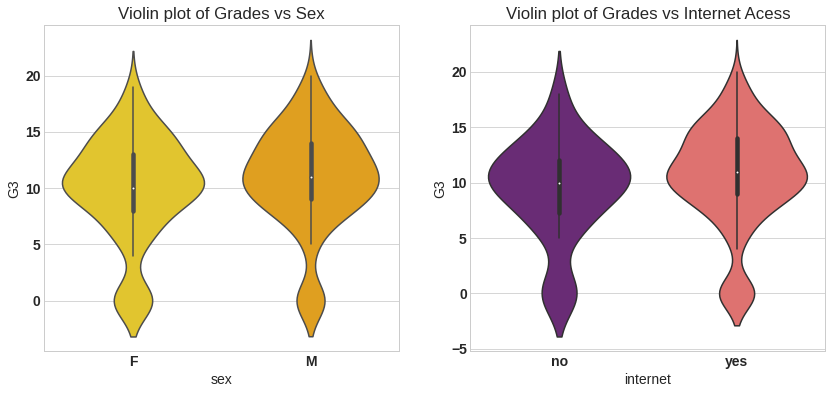

In [7]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='G3',data=df,palette='Wistia',ax=ax)
ax.set_title('Violin plot of Grades vs Sex')

ax = f.add_subplot(122)
sns.violinplot(x='internet', y='G3',data=df,palette='magma',ax=ax)
ax.set_title('Violin plot of Grades vs Internet Acess');



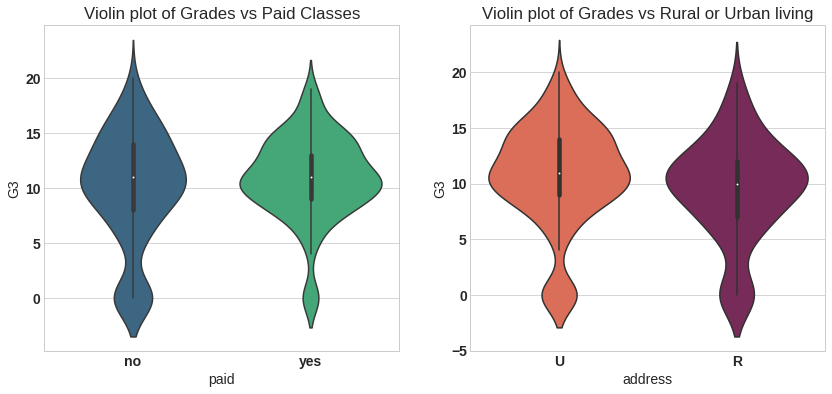

In [8]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='paid', y='G3',data=df,palette='viridis',ax=ax)
ax.set_title('Violin plot of Grades vs Paid Classes')

ax = f.add_subplot(122)
sns.violinplot(x='address', y='G3',data=df,palette='rocket_r',ax=ax)
ax.set_title('Violin plot of Grades vs Rural or Urban living');

We can see across multiple comparisons that the various independent variables share relatively the same averages.

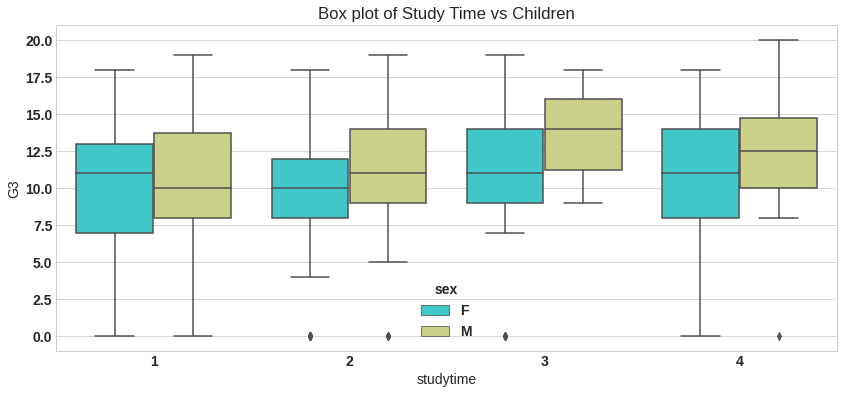

In [9]:
plt.figure(figsize=(14,6))
sns.boxplot(x='studytime', y='G3',hue='sex',data=df,palette='rainbow')
plt.title('Box plot of Study Time vs Children');

In [10]:
df.groupby('studytime').agg(['mean','min','max'])['G3']

,mean,min,max
studytime,,,
1,10.047619,0,19
2,10.171717,0,19
3,11.400000,0,19
4,11.259259,0,20


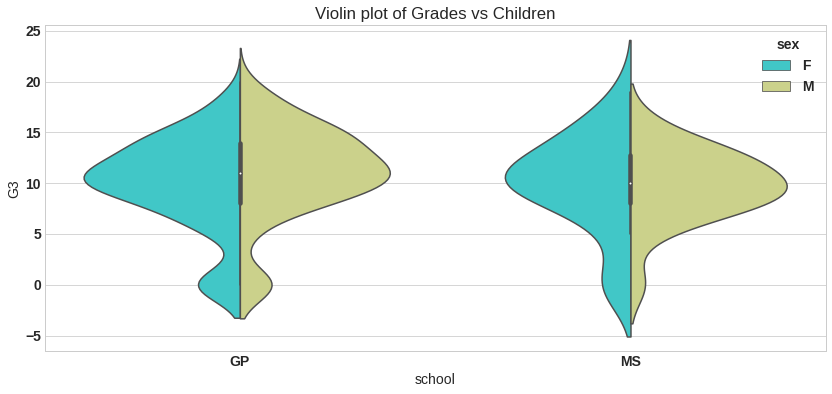

In [11]:
plt.figure(figsize=(14,6))
sns.violinplot(x='school', y='G3',hue='sex',data=df,palette='rainbow',split=True)
plt.title('Violin plot of Grades vs Children');


# Data Preprocessing

### Turn final grades into letter values
Above 90% = Grade A
Between 70% and 90% = Grade B
Below 70% = Grade C

In [12]:
# lets convert 

def define_grade(df):
    # Create a list to store the data
    grades = []

    # For each row in the column,
    for row in df['G3']:
        # if more than a value,
        if row >= (0.9 * df['G3'].max()):
            # Append a letter grade
            grades.append('A')
        # else, if more than a value,
        elif row >= (0.7 * df['G3'].max()):
            # Append a letter grade
            grades.append('B')
        # else, if more than a value,
        elif row < (0.7 * df['G3'].max()):
            # Append a letter grade
            grades.append('C')   
    # Create a column from the list
    df['grades'] = grades
    return df

In [13]:
df = define_grade(df)
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,grades
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,3,4,1,1,3,6,5,6,6,C
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,3,3,1,1,3,4,5,5,6,C
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,3,2,2,3,3,10,7,8,10,C
3,GP,F,15,U,GT3,T,4,2,health,services,...,2,2,1,1,5,2,15,14,15,B
4,GP,F,16,U,GT3,T,3,3,other,other,...,3,2,1,2,5,4,6,10,10,C


For our computations we ar enot going to use name of school or age feature, these values can be dropped.

In [14]:
df.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [15]:
df = df.drop(["school","age"], axis = 1)

In [16]:
df.describe()

,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


## Build Machine Learning Module
This model will utilize a DecisionTree algorithm to predict the results. Based on our exploratory data analysis there doesn't appear to be any good linear relationships. However first, computational values must be numerical.

In [17]:
# for yes / no values:
d = {'yes': 1, 'no': 0}
df['schoolsup'] = df['schoolsup'].map(d)
df['famsup'] = df['famsup'].map(d)
df['paid'] = df['paid'].map(d)
df['activities'] = df['activities'].map(d)
df['nursery'] = df['nursery'].map(d)
df['higher'] = df['higher'].map(d)
df['internet'] = df['internet'].map(d)
df['romantic'] = df['romantic'].map(d)

In [18]:
# map the sex data
d = {'F': 1, 'M': 0}
df['sex'] = df['sex'].map(d)

# map the address data
d = {'U': 1, 'R': 0}
df['address'] = df['address'].map(d)

# map the famili size data
d = {'LE3': 1, 'GT3': 0}
df['famsize'] = df['famsize'].map(d)

# map the parent's status
d = {'T': 1, 'A': 0}
df['Pstatus'] = df['Pstatus'].map(d)

# map the parent's job
d = {'teacher': 0, 'health': 1, 'services': 2,'at_home': 3,'other': 4}
df['Mjob'] = df['Mjob'].map(d)
df['Fjob'] = df['Fjob'].map(d)

# map the reason data
d = {'home': 0, 'reputation': 1, 'course': 2,'other': 3}
df['reason'] = df['reason'].map(d)

# map the guardian data
d = {'mother': 0, 'father': 1, 'other': 2}
df['guardian'] = df['guardian'].map(d)

# map the grades data
d = {'C': 0, 'B': 1, 'A': 2}
df['grades'] = df['grades'].map(d)

In [19]:
# let's see unique data values
df.nunique()

sex            2
address        2
famsize        2
Pstatus        2
Medu           5
Fedu           5
Mjob           5
Fjob           5
reason         4
guardian       3
traveltime     4
studytime      4
failures       4
schoolsup      2
famsup         2
paid           2
activities     2
nursery        2
higher         2
internet       2
romantic       2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
G1            17
G2            17
G3            18
grades         3
dtype: int64

Now we can collect predictive features column and remove it from our list

In [20]:
student_features = df.columns.tolist()
student_features.remove('grades')
student_features.remove('G3')
student_features.remove('G2')
student_features.remove('G1')
student_features

['sex',
 'address',
 'famsize',
 'Pstatus',
 'Medu',
 'Fedu',
 'Mjob',
 'Fjob',
 'reason',
 'guardian',
 'traveltime',
 'studytime',
 'failures',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic',
 'famrel',
 'freetime',
 'goout',
 'Dalc',
 'Walc',
 'health',
 'absences']

In [21]:
X = df[student_features].copy()
X.columns

Index(['sex', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob',
       'reason', 'guardian', 'traveltime', 'studytime', 'failures',
       'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
       'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc',
       'health', 'absences'],
      dtype='object')

In [22]:
y = df[["grades"]].copy()

Now we need to split the training data and the testing data.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, 
                                                    random_state=100)

Create classifier.

In [24]:
grade_classifier = tree.DecisionTreeClassifier(max_leaf_nodes=len(X.columns), 
                                               random_state= 0)
grade_classifier.fit(X_train, y_train)

DecisionTreeClassifier(max_leaf_nodes=28, random_state=0)

Lets view our decision tree using pydotplus library.

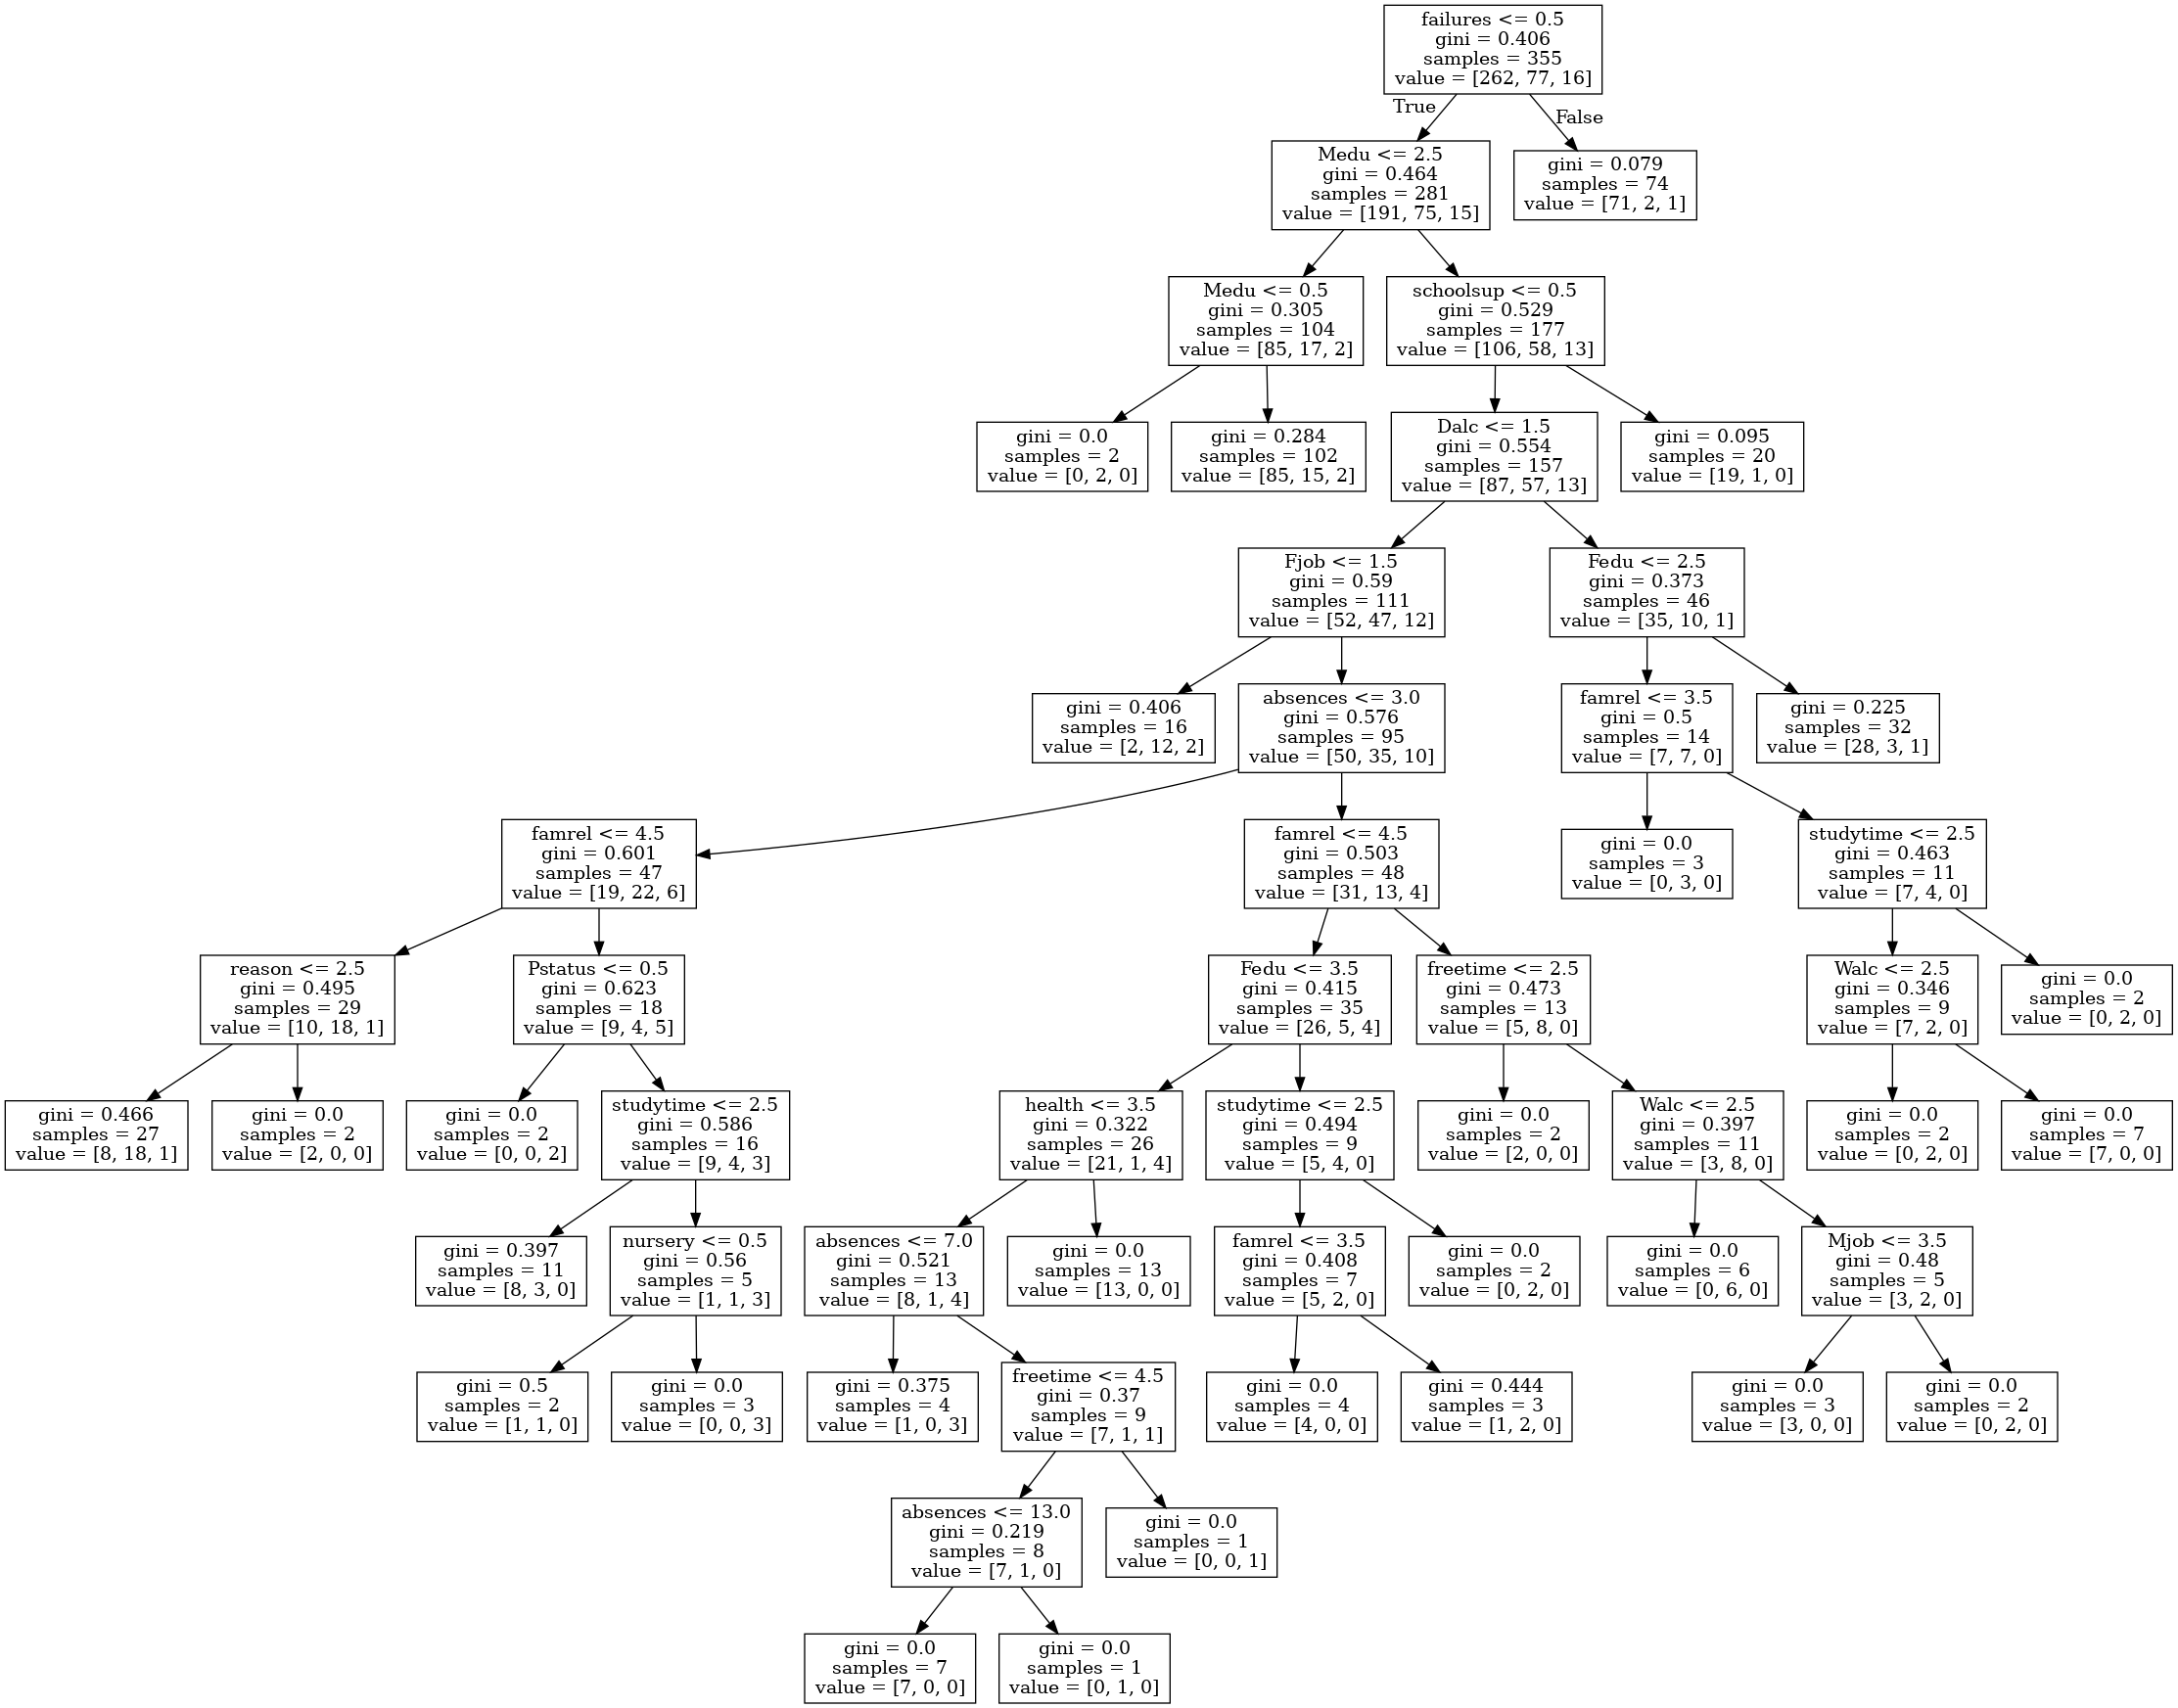

In [35]:
dot_data = StringIO()  
tree.export_graphviz(grade_classifier, out_file=dot_data,  
                         feature_names=student_features)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  

In [30]:
predictions = grade_classifier.predict(X_test)

In [31]:
accuracy_score(y_true = y_test, y_pred = predictions)

0.725

We can see that our accuracy is 0.725 which is not too bad.